# Figure 6 - Deconvolution of Single Cell RNA-Seq

Pip installation of required packages

In [1]:
#%%capture
#!pip install scanpy adjustText progressbar2 more_itertools leidenalg

In [1]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# Create the repo if it does not exist
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt
from more_itertools import collapse
import seaborn as sns
import textwrap
import ucdeconvolve as ucd_new
from ucdeconvolve_old import ucdeconvolve as ucd

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


2022-12-14 17:48:54.926729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:48:54.934712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:48:54.935389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:48:54.937060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
# Load the unicell basemodel
modelpath = "/home/jupyter/data/unicell_deconvolve_v2.2_10M.h5"
basemodel = tf.keras.models.load_model(modelpath, custom_objects={'tf': tf}, compile = False)

/opt/conda/lib/python3.7/site-packages/keras/layers/core.py:1045: UserWarning: unicell.tensorflow.deconvolve.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [3]:
from typing import List, Optional, Union, Tuple

def cell_cycle_scoring(
    adata : anndata.AnnData
) -> anndata.AnnData:
    """\
    Cell Cycle Scoring
    
    Utility function that performs cell cycle scoring on annotated dataset.
    
    Params
    ------
    adata
        an annotated dataset object
    
    Returns
    ------
    adata : anndata.AnnData
        an annotated dataset object with cell cycle scores in 'adata.obs'
        
    """
    
    #Open cell cycle genes from a reference file
    cell_cycle_genes = [x.strip() for x in open('data/cell_cycle_genes.txt')]

    # Separate S and G2M genes, and keep only those in the annotated dataset
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
    
    #Perform actual cell cycle scoring
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

    # Return result
    return adata


def preprocess_adata(
    adata : anndata.AnnData, 
    var_min_total_counts : int, 
    var_max_total_counts : int,
    var_min_genes_per_cell : int,
    var_max_genes_per_cell : int,
    var_mito_ratio_limit : int,
    var_gene_min_counts : int,
    normalize_target_sum : float,
    variable_genes_min_mean : float,
    variable_genes_max_mean : float,
    variable_genes_min_disp : float,
    regress_obs : List[str],
    max_scale_value : int,
    cell_cycle_regression : bool = True
) -> anndata.AnnData:
    """\
    Preprocess Annotated Dataset
    
    Performing preprocessing on raw annotated dataset using specificed parameters.
    
    Params
    ------
    adata
        An annotated dataset
    var_min_total_counts
        Minimum total counts per cell.
    var_max_total_counts
        Maximum total counts per cell.
    var_min_genes_per_cell
        Minimum number of genes per cell.
    var_max_genes_per_cell
        Maximum number of genes per cell.
    var_mito_ratio_limit
        Limit percentage of genes coming from
        mitochondria, a sign of damaged or
        dead cells.
    var_gene_min_counts
        Minimum counts for a gene to keep it.
    normalize_target_sum
        Number of counts to normalize each cell to.
    variable_genes_min_mean
        Minimum log mean for potential highly-variable gene.
    variable_genes_max_mean
        Maximum log mean for potential highly-variable gene.
    variable_genes_min_disp
        Minimum dispersion to consider a gene highly-variable.
    regress_obs
        Columns in obs to use for count regression.
    max_scale_value
        Max/min value (+/-) to use when z-score rescaling data.
    cell_cycle_regression
        Whether or not to do cell cycle regression. Default True.
        
    Returns
    ------
    adata : anndata.AnnData
        A preprocessed annotated dataset.
        
    """
    
    # Make gene names unique if they are not
    adata.var_names_make_unique()

    # Make all gene names uppercase
    adata.var_names = adata.var_names.str.upper()

    # Filter cells and genes by above thresholds
    sc.pp.filter_cells(adata, min_counts = var_min_total_counts, inplace = True)
    sc.pp.filter_cells(adata, max_counts = var_max_total_counts, inplace = True)
    sc.pp.filter_cells(adata, min_genes = var_min_genes_per_cell, inplace = True)
    sc.pp.filter_cells(adata, max_genes = var_max_genes_per_cell, inplace = True)
    #sc.pp.filter_genes(adata, min_counts = var_gene_min_counts, inplace = True)

    # Calculate QC metrics specific to mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top = None, log1p = False, inplace = True)

    # Keep cells with a mitochondrial fraction below the threshhold above
    adata = adata[adata.obs.pct_counts_mt < var_mito_ratio_limit, :]

    # Normalize UMI counts to 10,000 per cell 
    sc.pp.normalize_total(adata, target_sum=normalize_target_sum)

    # Logp-scale the data log(x + 1)
    sc.pp.log1p(adata)

    # Find highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=10, min_disp=0.25)

    # Set raw data to be equal to the normalized and log-scaled data
    adata.raw = adata

    # Only keep highly variable genes for downstream clustering operations
    adata = adata[:, adata.var.highly_variable]

    # Get cell-cycle genes
    if cell_cycle_regression: adata = cell_cycle_scoring(adata)
    
    # Regress out the effect of mitochondria and total counts
    # Also do cell cycle if desired
    if cell_cycle_regression:
        sc.pp.regress_out(adata, regress_obs + ['S_score','G2M_score'])
    else:
        sc.pp.regress_out(adata, regress_obs)

    # Rescale all data to unit variance
    sc.pp.scale(adata, max_value = max_scale_value)

    # Make data sparse prior to storage
    adata.X = scipy.sparse.csr_matrix(adata.X)

    return adata

def cluster_adata(adata : anndata.AnnData,
    var_pca_components : int, 
    var_n_neighbors : int, 
    var_umap_min_dist : float,
    use_rep : Optional[str] = None,
    harmony_batch : Optional[str] = 'batch',
    use_harmony : bool = False
) -> anndata.AnnData:
    """\
    Cluster Annotated Dataset
    
    Perform clustering according to parameters, including batch-correction.
    
    Params
    ------
    adata
        An annotated dataset
    var_pca_components
        Number of PCA components to generate.
    var_n_neighbors
        Number of nearest neighbors to use for clustering
    var_umap_min_dist
        Minimum distance for UMAP embedding.
    use_rep
        What rep to use for neighbors calculation, if None default is X_Pca
    harmony_batch
        What to use as batch key for harmony batch correction.
    use_harmony
        Whether or not to use harmony.
    
    Returns
    -------
    adata : anndata.AnnData
        An annotated datset with clustering and embedding data.
        
    """
    
    # Run PCA embedding
    sc.tl.pca(adata, svd_solver='arpack', n_comps = var_pca_components)
    
    # Run Harmony Batch Correction
    if use_harmony:
        sc.external.pp.harmony_integrate(adata, key = harmony_batch, 
                            basis = 'X_pca', adjusted_basis = 'X_pca_harmony')
        use_rep = 'X_pca_harmony'

    # Neighbors and UMAP embedding
    sc.pp.neighbors(adata, use_rep = use_rep, 
        n_neighbors = var_n_neighbors, n_pcs = var_pca_components)
    sc.tl.umap(adata, min_dist = var_umap_min_dist)
    
    #Unsupervised clustering and cluster enrichment
    sc.tl.leiden(adata)
    sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', use_raw = True)

    return adata

# Process Data

In [ ]:
adata_tumor = sc.read_10x_h5("data/BRP35045A-Tumor/filtered_feature_bc_matrix.h5")
adata_normal = sc.read_10x_h5("data/BRP35045B-AdjacentNormal/filtered_feature_bc_matrix.h5")

adata_normal.var_names_make_unique()
adata_tumor.var_names_make_unique()

adata = sc.concat([adata_tumor, adata_normal], label = 'batch', keys= ['Tumor', 'Normal'])
adata.write_h5ad("data/adata_nsclc_merged_raw.h5ad")

In [9]:
# Reload merged dataset
adata = sc.read_h5ad("data/adata_nsclc_merged_raw.h5ad")

# Preprocess raw data
adata = preprocess_adata(adata, 
            var_min_total_counts = 200, var_max_total_counts = 100000,
            var_min_genes_per_cell = 200, var_max_genes_per_cell = 50000,
            var_mito_ratio_limit = 10, var_gene_min_counts = 0, normalize_target_sum = 1E4, 
            variable_genes_min_mean = 0.0125, variable_genes_max_mean = 3,
            variable_genes_min_disp = 0.5, regress_obs = ['total_counts','pct_counts_mt'], max_scale_value = 10,
            cell_cycle_regression = True)

# Integrate with harmony, dimensionality reduce, cluster, and rank cluster DEGs
adata = cluster_adata(adata, var_pca_components = 75, var_n_neighbors = 30, 
            var_umap_min_dist = 0.1, harmony_batch = 'batch', use_harmony = True)

# Get deconvolutions
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [140]:
# Assign celltypes based on predictions

# Annotate
adata.obs['celltype'] = 'unknown'
adata.obs.loc[adata.obs.leiden.isin(('22','10','18','7','24')), 'celltype'] = 'type ii pneumocyte'
adata.obs.loc[adata.obs.leiden.isin(('20','')), 'celltype'] = 'lung ciliated cell'
adata.obs.loc[adata.obs.leiden.isin(('26','')), 'celltype'] = 'preadipocyte'
adata.obs.loc[adata.obs.leiden.isin(('8','14')), 'celltype'] = 'fibroblast of lung'
adata.obs.loc[adata.obs.leiden.isin(('12','')), 'celltype'] = 'smooth muscle cell'
adata.obs.loc[adata.obs.leiden.isin(('16','')), 'celltype'] = 'capillary endothelial cell'
adata.obs.loc[adata.obs.leiden.isin(('6','')), 'celltype'] = 'vein endothelial cell'
adata.obs.loc[adata.obs.leiden.isin(('21','')), 'celltype'] = 'endothelial cell of lymphatic vessel'
adata.obs.loc[adata.obs.leiden.isin(('3','')), 'celltype'] = 'endothelial cell of artery'
adata.obs.loc[adata.obs.leiden.isin(('23','')), 'celltype'] = 'macrophage'
adata.obs.loc[adata.obs.leiden.isin(('13','')), 'celltype'] = 'dendritic cell'
adata.obs.loc[adata.obs.leiden.isin(('19','0','5')), 'celltype'] = 'macrophage'
adata.obs.loc[adata.obs.leiden.isin(('25','')), 'celltype'] = 'neutrophil'
adata.obs.loc[adata.obs.leiden.isin(('15','')), 'celltype'] = 'basophil'
adata.obs.loc[adata.obs.leiden.isin(('2','')), 'celltype'] = 'effector memory cd4-positive, alpha-beta t cell'
adata.obs.loc[adata.obs.leiden.isin(('1','')), 'celltype'] = 'cd4-positive helper t cell'
adata.obs.loc[adata.obs.leiden.isin(('9','')), 'celltype'] = 'cd4-positive, cd25-positive, alpha-beta regulatory t cell'
adata.obs.loc[adata.obs.leiden.isin(('11','')), 'celltype'] = 'effector memory cd4-positive, alpha-beta t cell'
adata.obs.loc[adata.obs.leiden.isin(('4','')), 'celltype'] = 'cd8-positive, alpha-beta cytotoxic t cell'
adata.obs.loc[adata.obs.leiden.isin(('17','')), 'celltype'] = 'plasma cell'
adata.obs.loc[(ucd.tl.get_deconv_as_df(adata, category = 'primary')['natural killer cell'] > 0.4) &\
              (adata.obs.leiden.eq('4')),'celltype'] = 'natural killer cell'
adata.obs.loc[(ucd.tl.get_deconv_as_df(adata, category = 'primary')['monocyte'] > 0.4) &\
              (adata.obs.leiden.eq('13')),'celltype'] = 'monocyte'


In [193]:
# Save data
adata.write_h5ad("data/adata_nsclc_merged_pp.h5ad")

In [ ]:
# Subset epithelial cell types
adata_epi = adata[adata.obs.leiden.isin(('18','7','24','22','10'))].copy()

# Re-cluster with PCA, embedding, and neighbors / dim reduction
sc.pp.pca(adata_epi, n_comps=75)
sc.external.pp.harmony_integrate(adata_epi, key = 'batch')
sc.pp.neighbors(adata_epi, n_neighbors = 15, use_rep = 'X_pca_harmony')
sc.tl.umap(adata_epi, min_dist = 0.3)
sc.tl.leiden(adata_epi)

# Assign cell types
adata_epi.obs['celltype'] = 'unknown'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('4','12','3')), 'celltype'] = 'type ii pneumocyte'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('11','')), 'celltype'] = 'type i pneumocyte'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('10','')), 'celltype'] = 'club cell'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('8','')), 'celltype'] = 'basal cell'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('5','0','1','7','6','2')), 'celltype'] = 'luad'

# Save
adata_epi.write_h5ad("data/adata_nsclc_merged_pp_epi.h5ad")

In [290]:
# Calculate explanations and save as a CSV file
expl = dict()
for celltype in adata_epi.obs.celltype.unique().tolist():
    if celltype == 'unknown': continue
    expl[celltype] = ucd.tl.explain(adata_epi[adata_epi.obs.celltype.eq(celltype)], celltype, basemodel)
explanations = pd.concat([y for x,y in  expl.items()])
explanations.to_csv("data/explanations_lung_epi.csv", sep = ",")

Explaining Batches |   0% (0 of 49) |    | Elapsed Time: 0:00:00 ETA:  --:--:--2022-05-12 20:29:51.428704: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x558f2968a050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-12 20:29:51.428749: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-05-12 20:29:51.468539: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:133] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
2022-05-12 20:29:51.488365: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-05-12 20:30:04.070418: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Explaining Batches | 100% (49 of 49) |###| Elapsed Time: 0:

In [303]:
# WRite explanations
ucd.tl.write_explanations_to_anndata(adata_epi, expl['luad'], key = 'expl_luad')
ucd.tl.write_explanations_to_anndata(adata_epi, expl['club cell'], key = 'expl_club_cell')
ucd.tl.write_explanations_to_anndata(adata_epi, expl['type ii pneumocyte'], key = 'expl_atii_cell')
ucd.tl.write_explanations_to_anndata(adata_epi, expl['basal cell'], key = 'expl_basal_cell')
ucd.tl.write_explanations_to_anndata(adata_epi, expl['type i pneumocyte'], key = 'expl_ati_cell')
ucd.tl.write_explanations_to_anndata(adata_epi, explanations, key = 'expl_all')

In [308]:
# Save explanations
adata_epi.write_h5ad("data/adata_nsclc_merged_pp_epi_expl.h5ad")

## Run CNV Inference

In [348]:
import pandas as pd
import math
from typing import List,Union
from anndata import AnnData

def append_gene_positions(adata : Union[AnnData, pd.DataFrame], genefile = "data/unicell_genepos_human.txt"):
    
    # Confirm its the right type
    if not isinstance(adata, (AnnData, pd.DataFrame)):
        raise TypeError('adata must be a anndata or DataFrame object')

    # Load gene positions
    positions = pd.read_csv(genefile, sep = "\t").set_index('symbol').rename(columns = {'chr' : 'chromosome'})
    positions.chromosome = positions.chromosome.map(lambda s : 'chr' + s if s not in ('X','Y') else s)
    
    if isinstance(adata, AnnData):
        if not any([x in adata.var.columns for x in ['chromosome', 'start','end']]):
            adata.var = adata.var.merge(positions, left_index = True, right_index = True, how = 'left')
        return adata
    elif isinstance(adata, pd.DataFrame):
        adata = adata.merge(positions, left_index = True, right_index = True, how = 'left')
        return adata
    else:
        raise TypeError('adata must be a anndata or DataFrame object')

In [358]:
import infercnvpy as cnv

In [356]:
# Extract raw
adata_raw = adata.raw.to_adata()
adata_raw = append_gene_positions(adata_raw)

In [363]:
# Run inferCNV using celltype references from endothelial, smooth muscle, and lung ciliated cells.
cnv.tl.infercnv(
    adata_raw,
    reference_key="celltype",
    reference_cat=[
        "endothelial cell of artery",
        "vein endothelial cell",
        "smooth muscle cell",
        "capillary endothelial cell",
        "endothelial cell of lymphatic vessel",
        "lung ciliated cell",
        "macrophage",
        "fibroblast of lung"],
    window_size=100)

  0%|          | 0/4 [00:00<?, ?it/s]

In [389]:
adata_epi.obsm['X_cnv'] = adata_raw[adata_epi.obs_names].obsm['X_cnv']
cnv.tl.cnv_pca(adata_epi)
cnv.tl.cnv_neighbors(adata_epi)
cnv.tl.cnv_leiden(adata_epi)
cnv.tl.cnv_umap(adata_epi)
cnv.tl.cnv_score(adata_epi)
adata_epi.obs['cnv_score_indv'] = np.array(np.abs(adata_epi.obsm['X_cnv'].mean(1).flatten())).flatten()

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


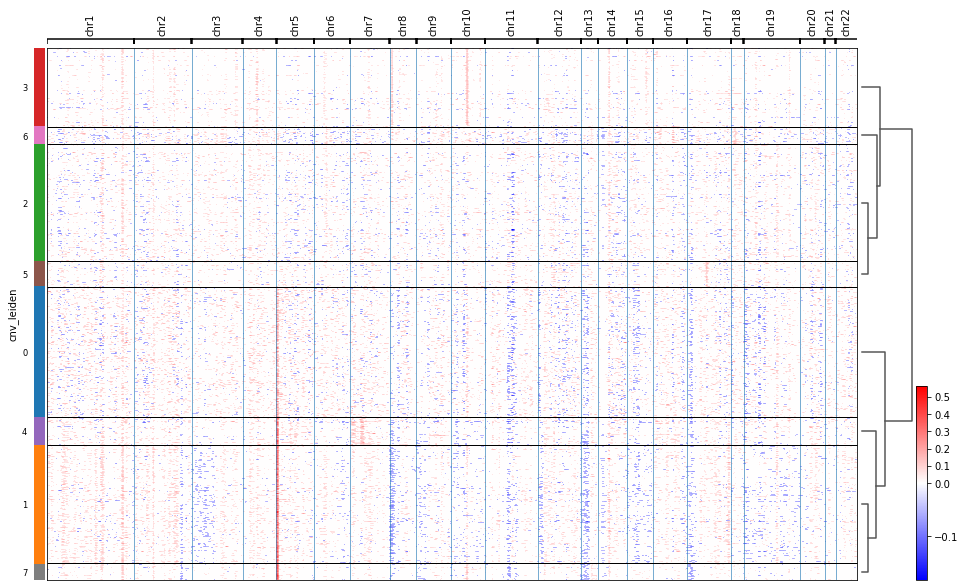

In [375]:
cnv.pl.chromosome_heatmap(adata_raw_epi, groupby="cnv_leiden", dendrogram = True, )

In [494]:
# Save CNV
adata_epi.write_h5ad("data/adata_nsclc_merged_pp_epi_expl_cnv.h5ad")

# Plot Supplementary Figure 6

In [5]:
# Reload data
adata = sc.read_h5ad("data/adata_nsclc_merged_pp.h5ad")
adata_epi = sc.read_h5ad("data/adata_nsclc_merged_pp_epi.h5ad")

## Panel A

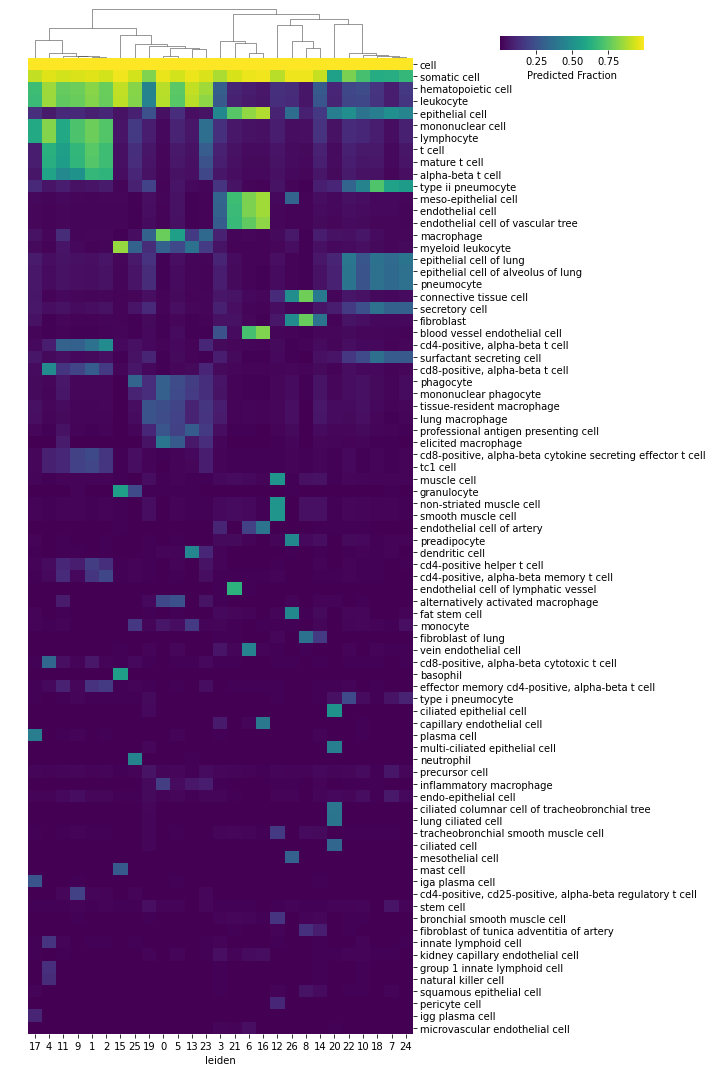

In [122]:
from more_itertools import collapse
import seaborn as sns
n_top = 14
celltype_preds = ucd.tl.get_deconv_as_df(adata, category = 'primary').groupby(adata.obs.leiden).mean()
top_celltypes = list(set(list(collapse(celltype_preds.apply(lambda x : x.sort_values(ascending = False).head(n_top).index.tolist(), axis = 1).tolist()))))
celltypes_rank= celltype_preds[top_celltypes].mean(0).sort_values(ascending = False).index.tolist()

g1 = sns.clustermap(celltype_preds[top_celltypes].T.reindex(celltypes_rank), yticklabels = True, xticklabels = True, cmap = 'viridis', dendrogram_ratio=0.05,
              cbar_pos = (0.7,0.95, 0.2, 0.0125), figsize = (10,15), 
                    row_cluster=False, metric = 'cosine',
                    cbar_kws={'orientation' : 'horizontal', 'label' : 'Predicted Fraction'})

g1.savefig("results/supplement6_A.png", dpi = 300)

## Panel B

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


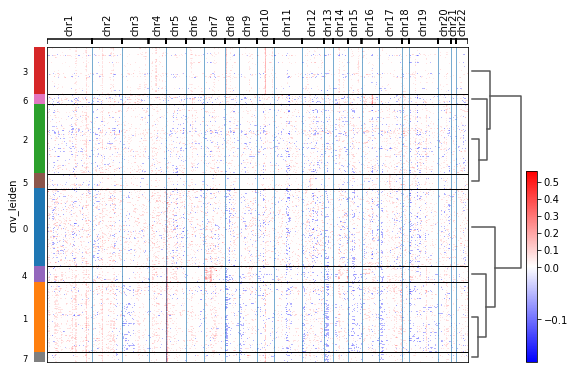

In [501]:
results = cnv.pl.chromosome_heatmap(adata_raw_epi, groupby="cnv_leiden", dendrogram = True, figsize=(9, 6), show = False)
results['heatmap_ax'].get_figure().savefig("results/supplement6_B_top.png")

(9, 3)


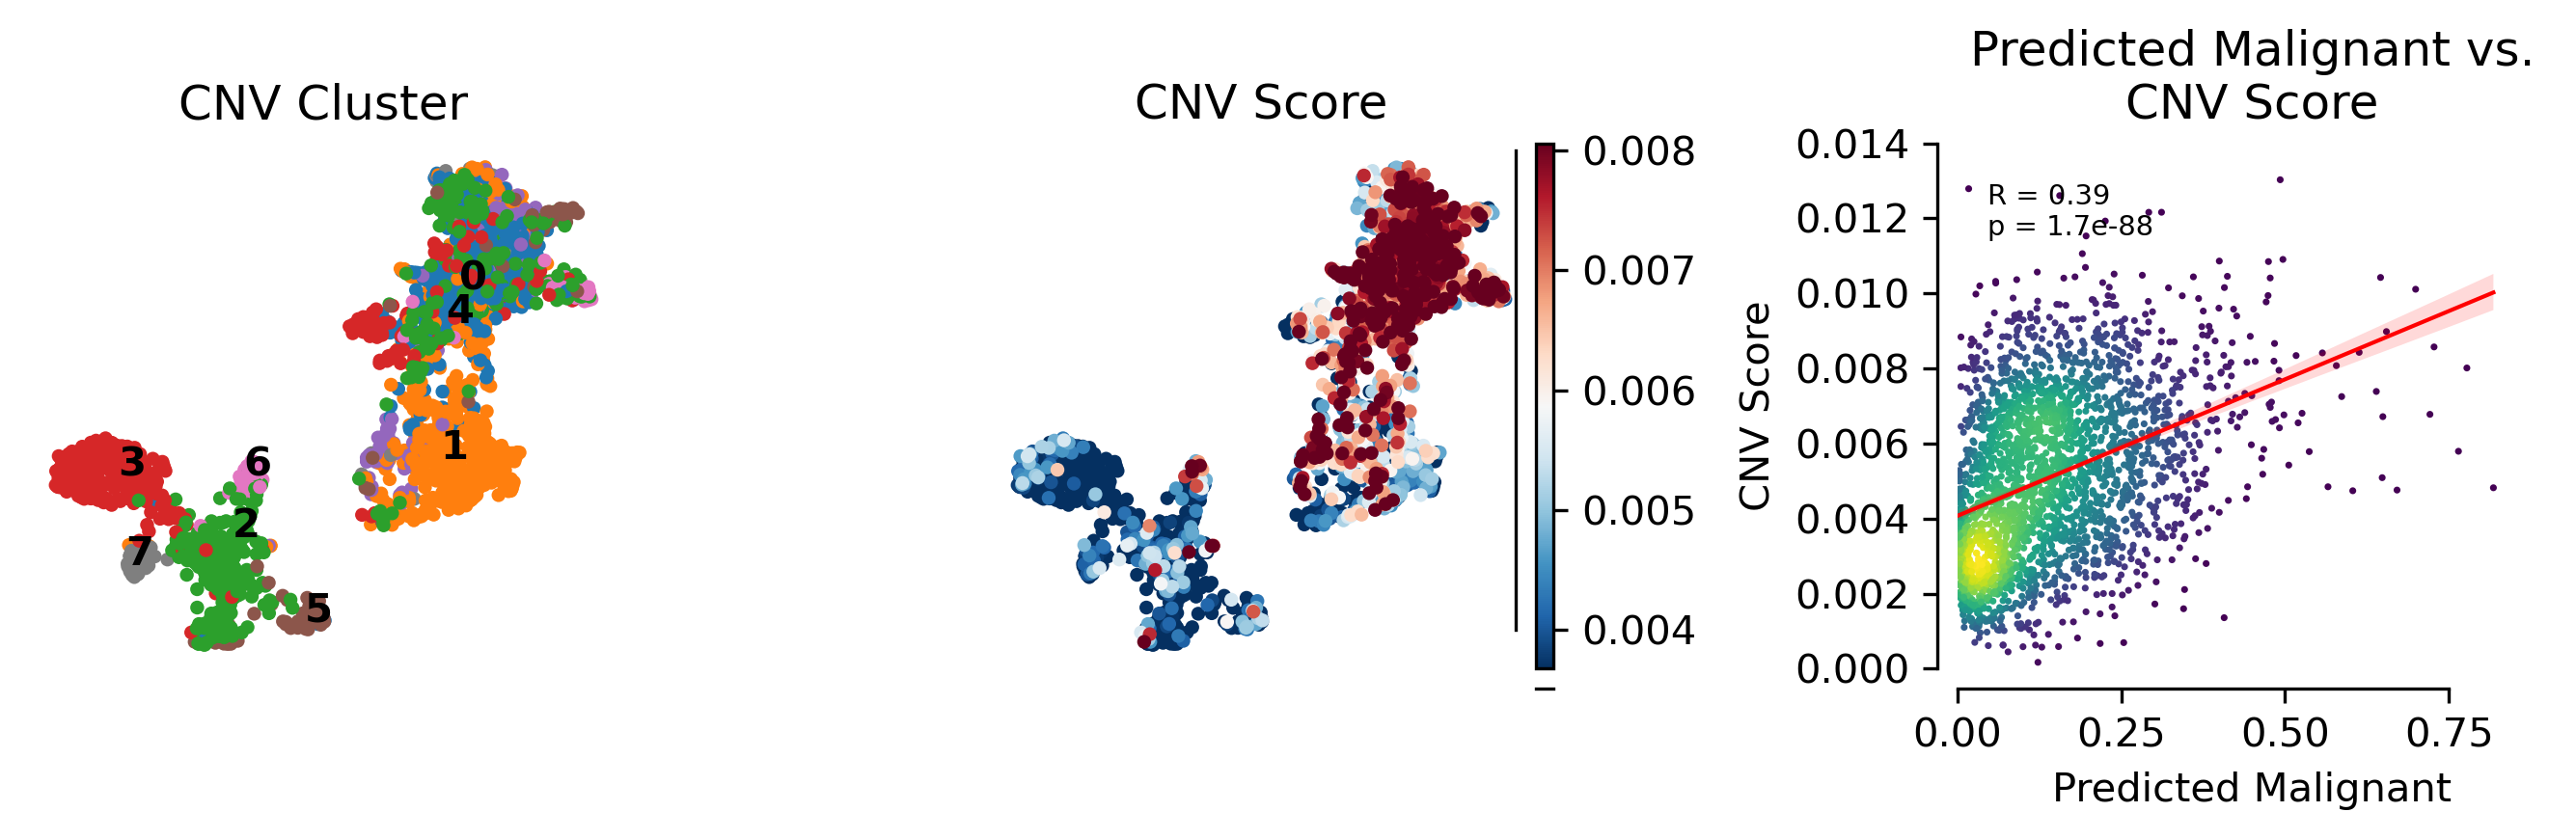

In [496]:
x = adata_epi.obs['malignant cell'].values
y = adata_epi.obs['cnv_score_indv'].values


df = pd.DataFrame({'malignant_pred' : x, 'cnv_score' : y})

with ucd.pl.FigContext(1, 3, dpi = 300, figsize = (3,3), despine=True,
                       simple_axes_padding=True, do_adjust_labels=False) as axes:
    
    
    # CNv score clusters
    sc.pl.embedding(adata_epi, basis = "X_umap", color = "cnv_leiden", ax = axes[0], show = False,
                vmax = "p90", vmin = "p30", cmap = 'RdBu_r', legend_loc = 'on data', frameon = False,
                   title = 'CNV Cluster')
    
    # CNv score clusters
    sc.pl.embedding(adata_epi, basis = "X_umap", color = "cnv_score_indv", ax = axes[1], show = False,
                vmax = "p90", vmin = "p30", cmap = 'RdBu_r', legend_loc = 'on data', frameon = False,
                   title = 'CNV Score')
    
    # Predicted malignant vs. cnv score correlation
    ucd.pl.scatter(df, 'malignant_pred', 'cnv_score', 
                   show_ccc = False, 
                   xlims=(0.0, 0.9), 
                   ylims = (0.0, 0.014),
                   draw_identity=False,
                  colorbydensity=True, ax = axes[2],
                  title = 'Predicted Malignant vs.\nCNV Score')
    
    axes[2].set_xlabel("Predicted Malignant")
    axes[2].set_ylabel("CNV Score")
    
    
    axes[2].get_figure().savefig("results/supplement6_B_bottom.png", dpi = 300)

## Panel C

(16, 4)


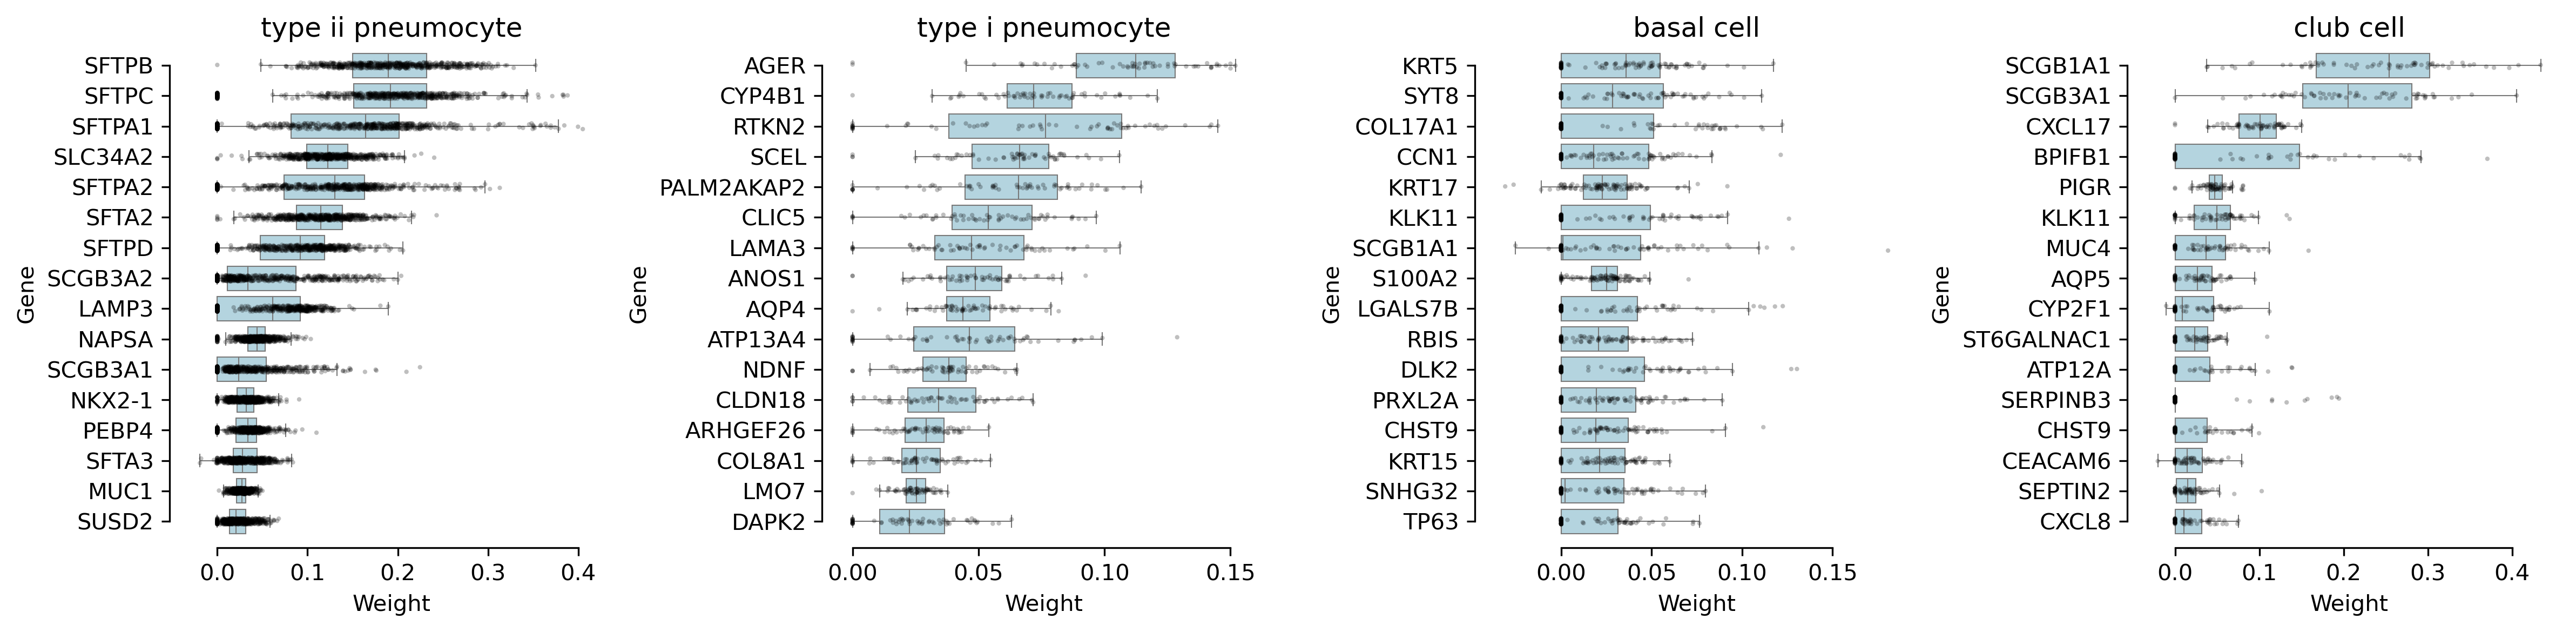

In [325]:
with ucd.pl.FigContext(1, 4, dpi = 300, figsize = (4,4), despine=True, simple_axes_padding=False, do_adjust_labels=False) as axes:
    
    
    celltypes = ['type ii pneumocyte', 'type i pneumocyte', 'basal cell', 'club cell']
    expl_keys = ['expl_atii_cell', 'expl_ati_cell', 'expl_basal_cell', 'expl_club_cell']
    for celltype, expl_key, ax in zip(celltypes, expl_keys, axes):
        
        ucd.pl.explain(adata_epi, 
                       subset = adata_epi.obs.celltype.eq(celltype).pipe(lambda x : x[x]).index,
                       celltype = celltype, 
                       expl_key=expl_key, ax = ax)

        ax.set_title(celltype)
        ax.set_xlabel("Weight")
        ax.set_ylabel("Gene")

# Plot Figure 6

## Panel B

(3, 3)


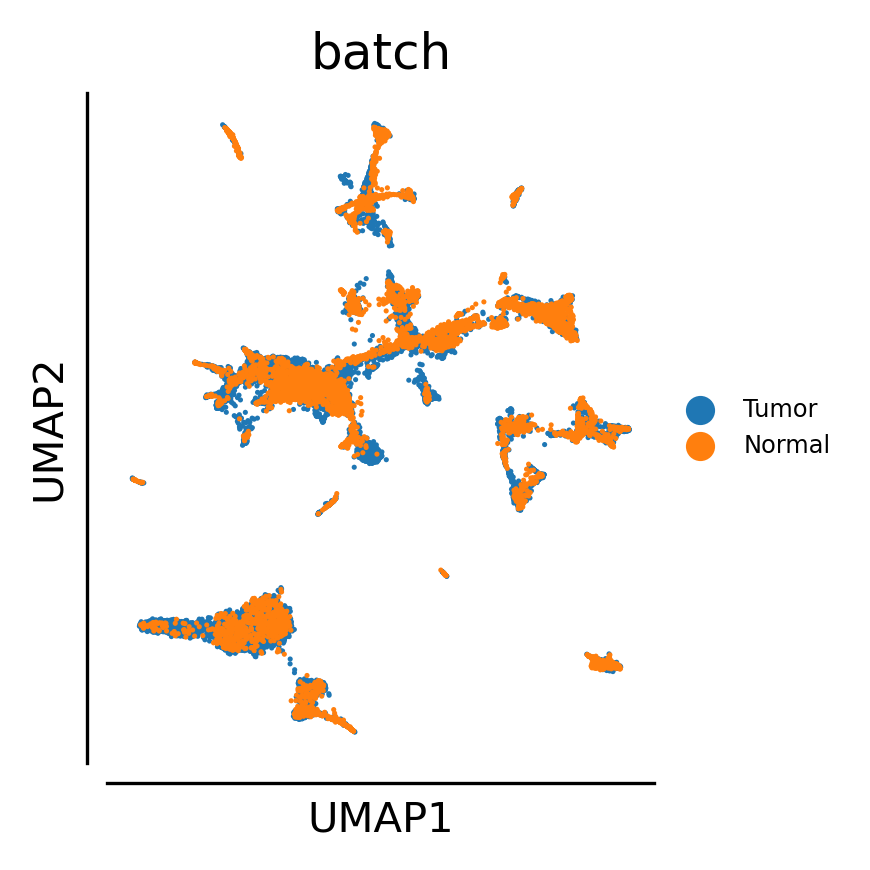

In [175]:
with ucd.pl.FigContext(dpi = 300, figsize = (3,3), despine=True,
                       simple_axes_padding=True, do_adjust_labels=False) as ax:
    adata.obs['celltype_label'] = adata.obs.celltype.apply(lambda x : textwrap.fill(x, 30))
    sc.pl.umap(adata, color = 'batch', ax = ax, legend_fontsize='xx-small', show = False)
    ax.get_figure().savefig("results/figure6_B_right.png")

(3, 3)


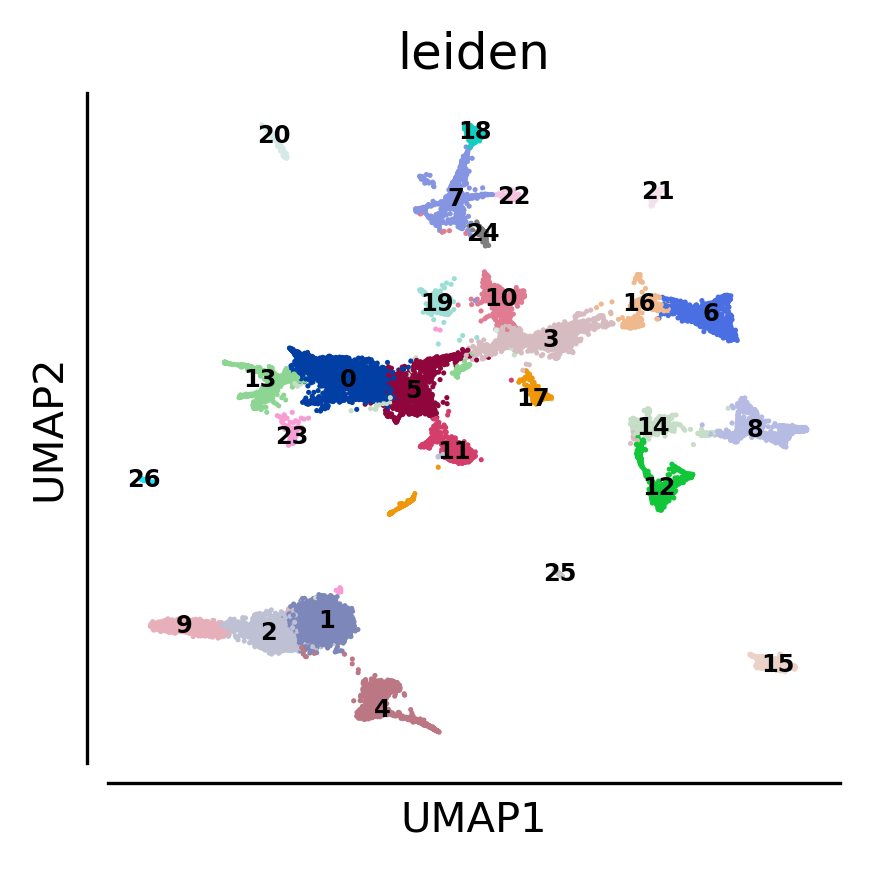

In [176]:
with ucd.pl.FigContext(dpi = 300, figsize = (3,3), despine=True,
                       simple_axes_padding=True, do_adjust_labels=False) as ax:
    adata.obs['celltype_label'] = adata.obs.celltype.apply(lambda x : textwrap.fill(x, 30))
    sc.pl.umap(adata, color = 'leiden', ax = ax, legend_fontsize='xx-small', show = False, legend_loc = 'on data')
    ax.get_figure().savefig("results/figure6_B_left.png")

## Panel C

(4, 4)


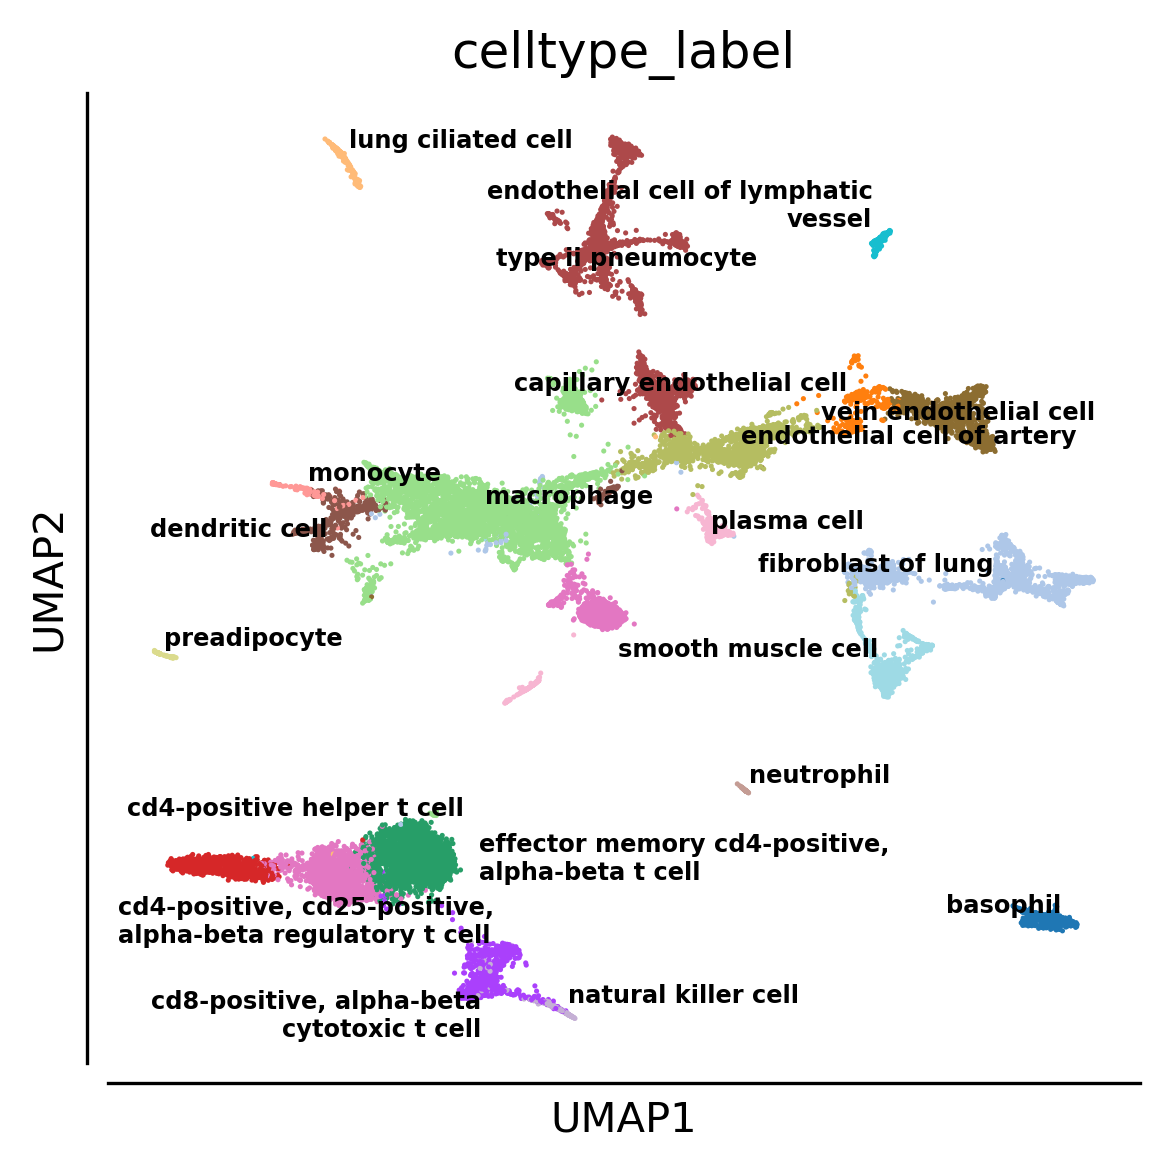

In [173]:
with ucd.pl.FigContext(dpi = 300, figsize = (4,4), despine=True,
                       simple_axes_padding=True, do_adjust_labels=True) as ax:
    adata.obs['celltype_label'] = adata.obs.celltype.apply(lambda x : textwrap.fill(x, 30))
    sc.pl.umap(adata, color = 'celltype_label', ax = ax, legend_fontsize='xx-small', show = False, legend_loc = 'on data')
    
    ax.get_figure().savefig("results/figure6_C.png")

## Panel D

(3, 3)


... storing 'chromosome' as categorical


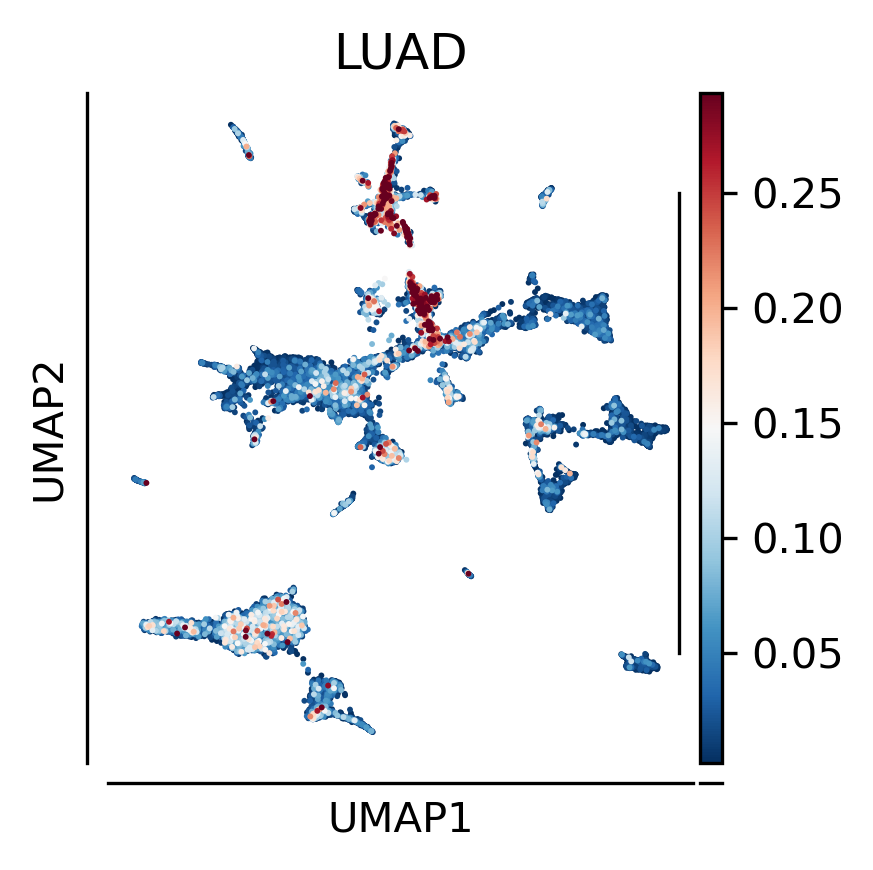

In [506]:
with ucd.pl.FigContext(dpi = 300, figsize = (3,3), despine=True, simple_axes_padding=True, do_adjust_labels=False) as ax:
    ucd.pl.deconvolution(adata, celltype = 'luad', category = 'cancer', size = 8, show = False, ax = ax, title = 'LUAD',
                        vmin = "p20", vmax = "p99.2")
    ax.get_figure().savefig("results/figure6_D_left.png")

## Panel D

In [196]:
# Subset epithelial cell types
adata_epi = adata[adata.obs.leiden.isin(('18','7','24','22','10'))].copy()

# Re-cluster with PCA, embedding, and neighbors / dim reduction
sc.pp.pca(adata_epi, n_comps=75)
sc.external.pp.harmony_integrate(adata_epi, key = 'batch')
sc.pp.neighbors(adata_epi, n_neighbors = 15, use_rep = 'X_pca_harmony')
sc.tl.umap(adata_epi, min_dist = 0.3)
sc.tl.leiden(adata_epi)

# Assign cell types
adata_epi.obs['celltype'] = 'unknown'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('4','12','3')), 'celltype'] = 'type ii pneumocyte'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('11','')), 'celltype'] = 'type i pneumocyte'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('10','')), 'celltype'] = 'club cell'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('8','')), 'celltype'] = 'basal cell'
adata_epi.obs.loc[adata_epi.obs.leiden.isin(('5','0','1','7','6','2')), 'celltype'] = 'luad'

# Save
adata_epi.write_h5ad("data/adata_nsclc_merged_pp_epi.h5ad")

(3, 1.5)


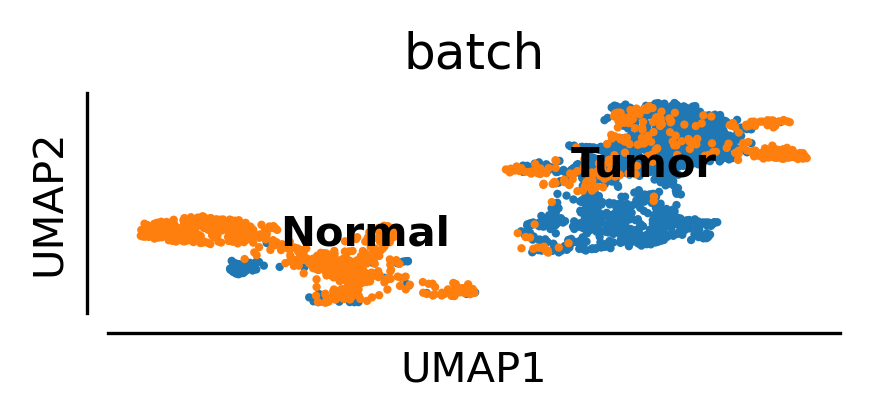

In [507]:
with ucd.pl.FigContext(dpi = 300, figsize = (3,1.5), despine=True, simple_axes_padding=True, do_adjust_labels=False) as ax:
    sc.pl.umap(adata_epi, color = 'batch',size = 16, ax = ax, show = False, legend_loc = 'on data')
    ax.get_figure().savefig("results/figure6_D_right_top.png")

(3, 1.5)


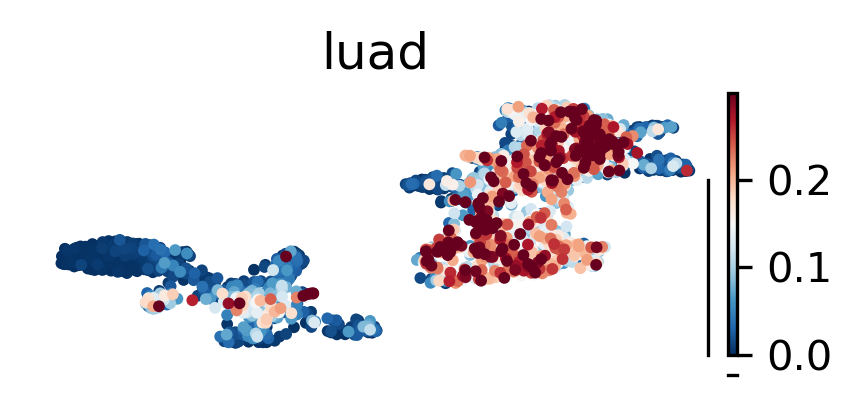

In [511]:
with ucd.pl.FigContext(dpi = 300, figsize = (3,1.5), despine=True, simple_axes_padding=True, do_adjust_labels=False) as ax:
    ucd.pl.deconvolution(adata_epi, celltype = 'luad', category = 'cancer', 
                             frameon = False, vmax = "0.3", vmin = "0", 
                             size = 32, ax = ax, show = False)
    
    ax.get_figure().savefig("results/figure6_D_right_bottom.png")

## Panel E

(6, 6)


... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle thick ascending limb epithelial cell' as categorical
... storing 'kidney loop of henle epithelial cell' as categorical
... storing 'kid

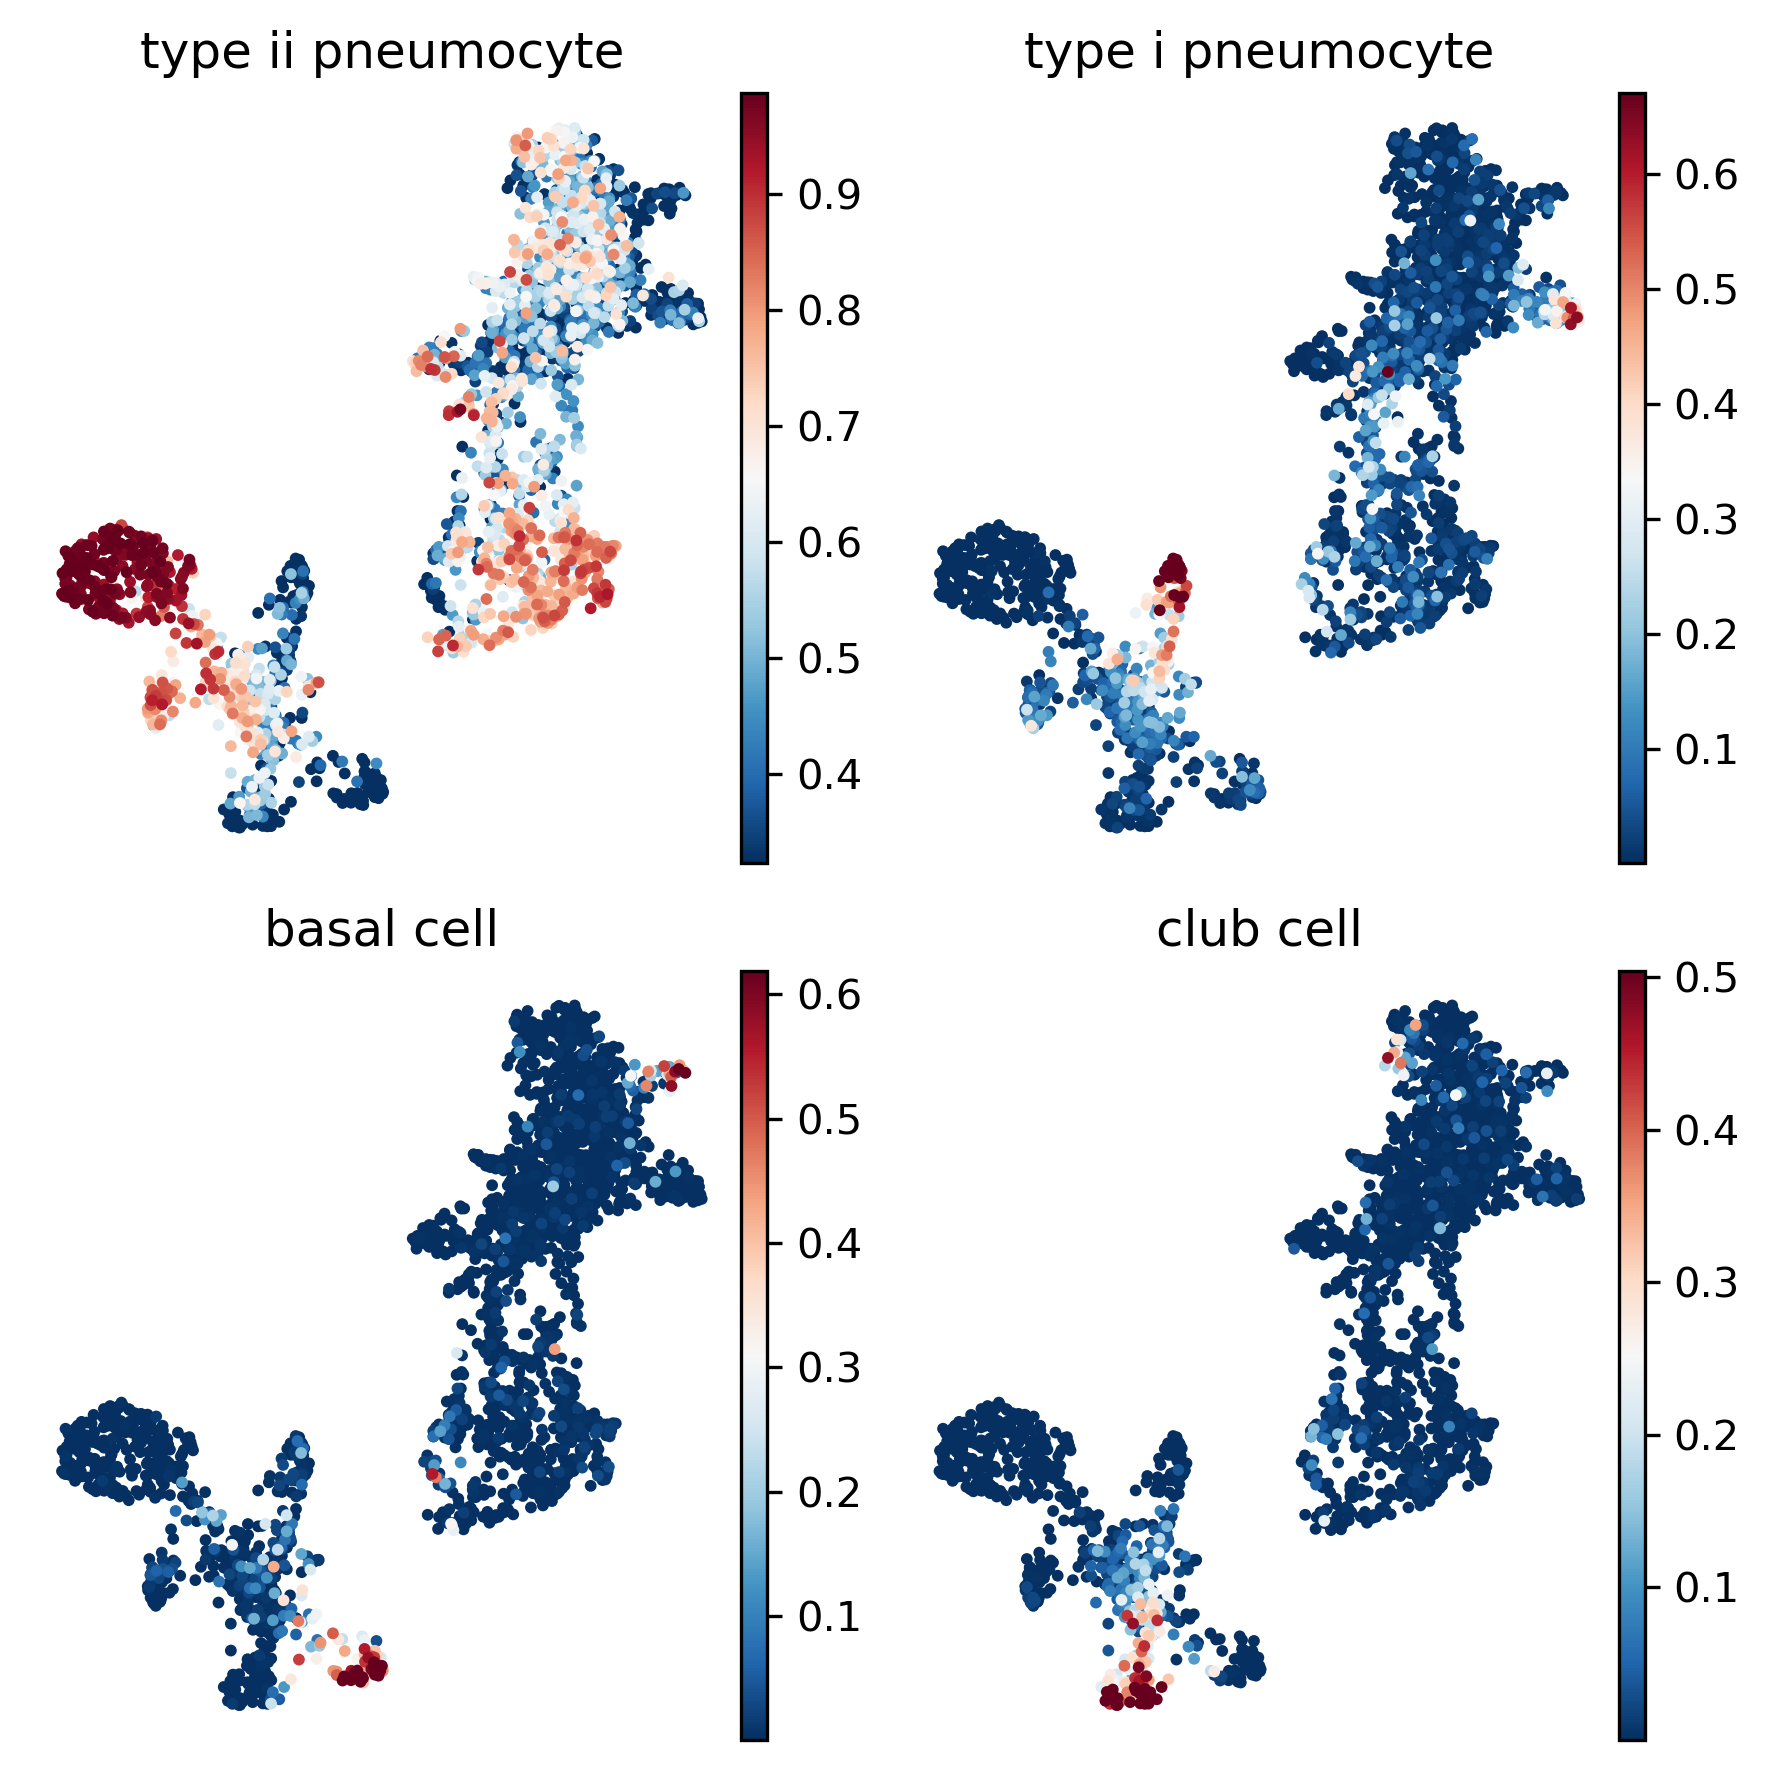

In [512]:
with ucd.pl.FigContext(2, 2, dpi = 300, figsize = (3,3), despine=False, simple_axes_padding=False, do_adjust_labels=False) as axes:
    celltypes = ['type ii pneumocyte', 'type i pneumocyte', 'basal cell', 'club cell']
    for celltype, ax in zip(celltypes, axes):
        ucd.pl.deconvolution(adata_epi, celltype = celltype, category = 'primary', 
                             frameon = False, vmax = "p99.2", vmin = "p20", 
                             size = 32, ax = ax, show = False)
    ax.get_figure().savefig("results/figure6_E.png")

## Panel F

(4, 4)


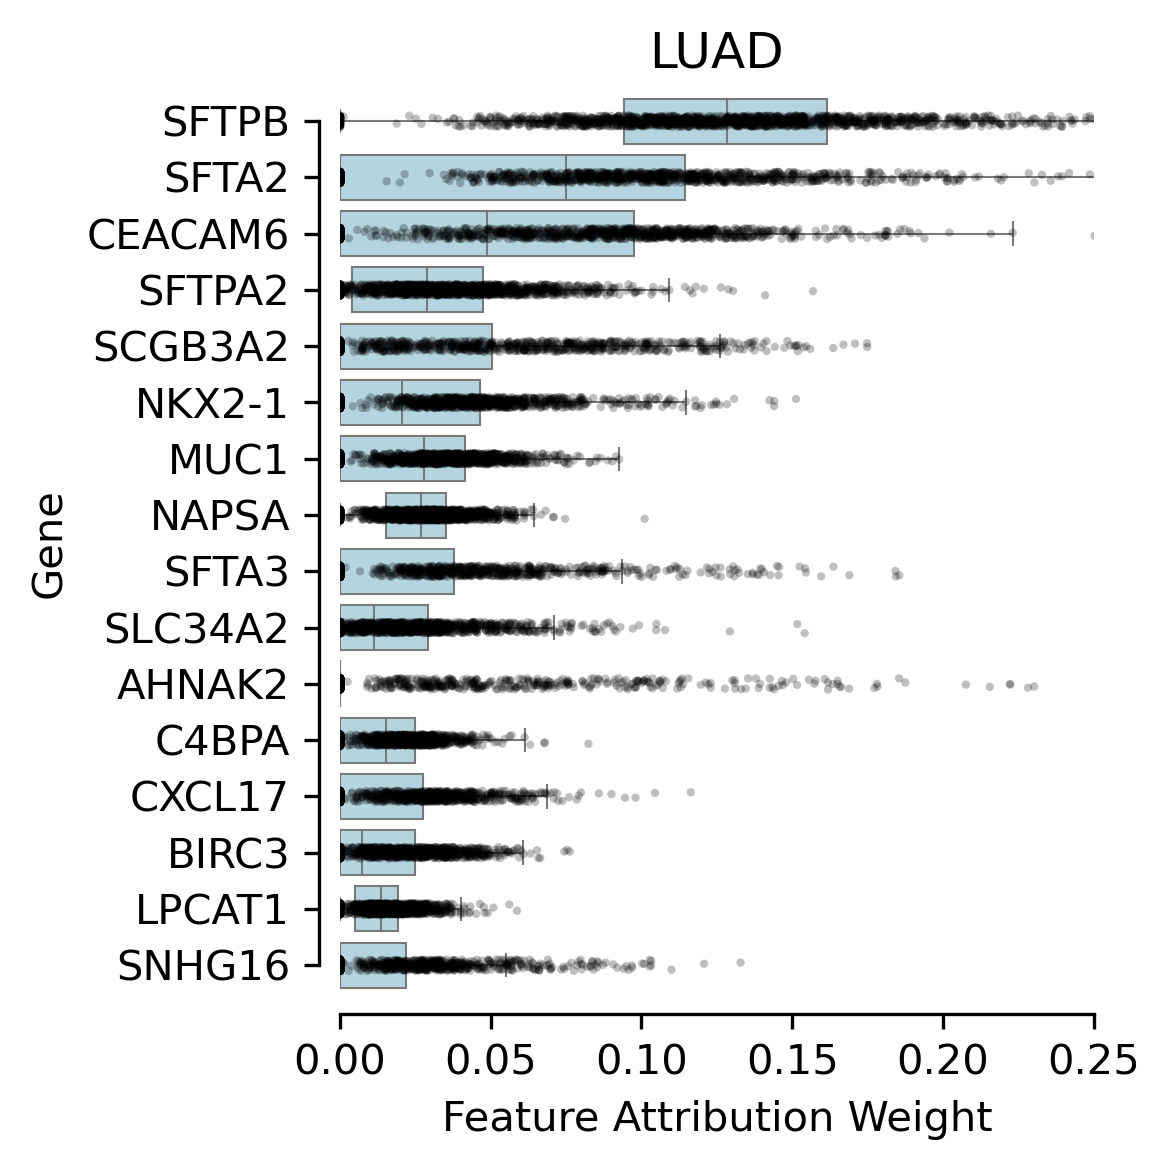

In [513]:
with ucd.pl.FigContext(dpi = 300, figsize = (4,4), despine=True, simple_axes_padding=False, do_adjust_labels=False) as ax:
    
    ucd.pl.explain(adata_epi, 
                   subset = adata_epi.obs.celltype.eq('luad').pipe(lambda x : x[x]).index,
                   celltype = 'luad', 
                   expl_key='expl_luad', ax = ax)
    
    ax.set_title("LUAD")
    ax.set_xlabel("Feature Attribution Weight")
    ax.set_ylabel("Gene")
    ax.set_xlim(0.0, 0.25)
    
    ax.get_figure().savefig("results/figure6_F.png")

# Plot Supplementary Figures

In [76]:
# Reload data
adata = sc.read_h5ad("data/adata_nsclc_merged_pp.h5ad")
adata_epi = sc.read_h5ad("data/adata_nsclc_merged_pp_epi.h5ad")

adata.obs['celltype'] = adata.obs['celltype'].astype(str)
adata.obs.loc[adata_epi.obs_names, "celltype"] = adata_epi.obs['celltype'].astype(str).values
adata.obs['celltype'] = adata.obs['celltype'].astype('category')
adata = adata[adata.obs.celltype_label.ne('unknown')]

In [ ]:
# Calculate explanations 
expl = dict()
for celltype in tqdm(adata.obs.celltype.unique().tolist()):
    if celltype == 'unknown': continue
    expl[celltype] = ucd.tl.explain(adata[adata.obs.celltype.eq(celltype)], celltype, basemodel)
explanations = pd.concat([y for x,y in  expl.items()])

# Pool top 5 explanations for each cell type
var_names = {celltype : [x for x in explanations.loc[celltype].mean(0).sort_values(ascending = False).head(5).index.tolist() if\
                            x in adata.raw.var_names] for
     celltype in adata.obs['celltype'].unique() if celltype != 'unknown'}

In [112]:
# Plot
fig, ax = plt.subplots(1,1, dpi = 600, figsize = (24,8))
sc.pl.dotplot(adata, groupby = 'celltype', mean_only_expressed = True, var_names = var_names, 
              dendrogram=True, swap_axes = False, expression_cutoff = 0.25, dot_min = 0.25, ax = ax, show = True)

categories: basal cell, basophil, capillary endothelial cell, etc.
var_group_labels: macrophage, luad, cd8-positive, alpha-beta cytotoxic t cell, etc.
